In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
main_folder_path = "/kaggle/input/cropped-faces/cropped_faces"

# Calculating the Average height & width

In [3]:
total_width = 0
total_height = 0
num_images = 0
for folder in os.listdir(main_folder_path):
    category_path = os.path.join(main_folder_path, folder)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = Image.open(image_path)
        
        width, height = image.size
        
        total_width += width
        total_height += height
        num_images += 1

# Total no of images

In [4]:
num_images

734

# Avg height & width

In [5]:
avg_width = total_width/num_images
avg_height = total_height/num_images
print("Average width:- ",avg_width)
print("Average height:- ",avg_height)

Average width:-  297.54768392370573
Average height:-  297.54768392370573


# Preprocessing and splitting into Train & Test

In [6]:
train_list = []
test_list = []
target_size = (224, 224)
for folder in os.listdir(main_folder_path):
    category_path = os.path.join(main_folder_path, folder)
    count = 0
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = Image.open(image_path)
        
        # Resize the image to the desired size (e.g., 224x224 pixels)
        
        resized_image = image.resize(target_size, Image.ANTIALIAS)
        
        # Convert the resized image to grayscale
        grayscale_image = resized_image.convert("L")
        
        image_array = np.array(grayscale_image)
        
        image_array = np.ravel(image_array)
        if count <= 2:
            test_list.append([image_array,folder])
        else:
            train_list.append([image_array,folder])
        
        count += 1

/tmp/ipykernel_33/660704994.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


# Calculating Mean Face

In [7]:
# Extract all 1D NumPy arrays from the data list
arrays = [item[0] for item in train_list]

# Calculate the mean of all arrays
mean_image = np.mean(arrays, axis=0)

print("Mean of all arrays:")
print(mean_image)

Mean of all arrays:
[179.98296422 177.86882453 175.55536627 ... 145.93015332 146.70868825
 147.66950596]


In [8]:
arrays[0].shape

(50176,)

In [9]:
mean_image.shape

(50176,)

In [10]:
# Reshape the 1D array into a 2D matrix
grayscale_image = mean_image.reshape(target_size)

# Displaying Mean Face

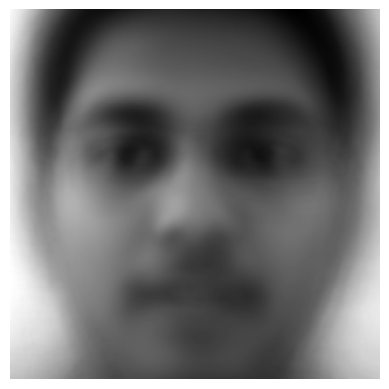

In [11]:
# Display the grayscale image
plt.imshow(grayscale_image, cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Calculating Shifted Faces

In [12]:
shifted_images = arrays - mean_image

In [13]:
shifted_images.shape

(587, 50176)

In [14]:
modified_images = shifted_images.T

In [15]:
modified_images.shape

(50176, 587)

# Covariance Matrix of Shifted Faces

In [16]:
covariance_matrix = np.cov(modified_images,rowvar = False)

In [17]:
covariance_matrix.shape

(587, 587)

# Calculating the Eigen Faces

In [18]:
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

# Selecting top K Eigen Faces

In [19]:
# Sort eigen vectors based on eigen values
k = 100
sorted_indices = np.argsort(eigen_values)[::-1]
top_k_indices = sorted_indices[:k]
top_k_eigen_vectors = eigen_vectors[:, top_k_indices]

In [20]:
top_k_eigen_vectors.shape

(587, 100)

In [21]:
eigen_vector = modified_images@top_k_eigen_vectors

In [22]:
eigen_vector.shape

(50176, 100)

# Displaying the top 10 Eigen Faces

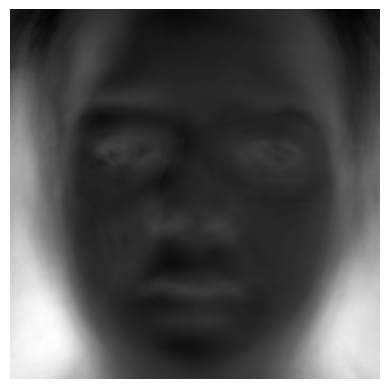

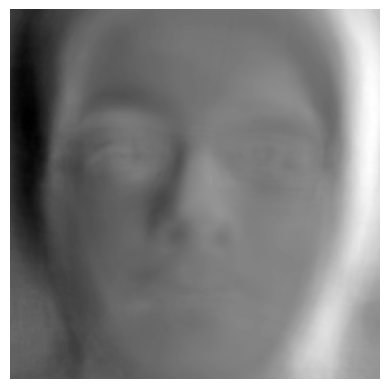

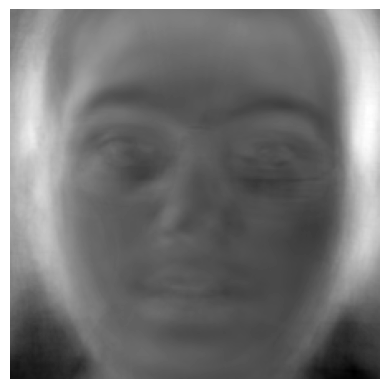

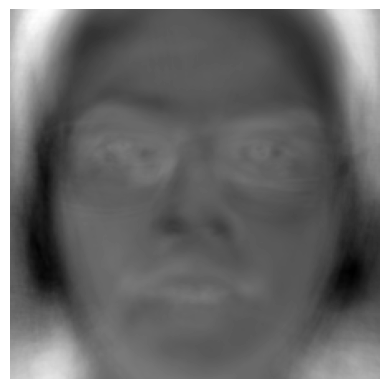

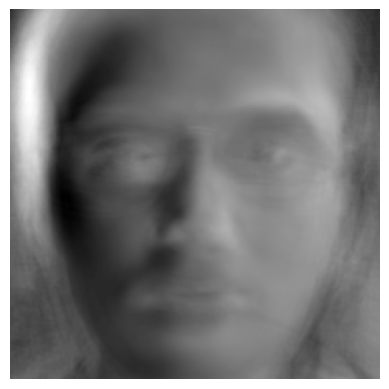

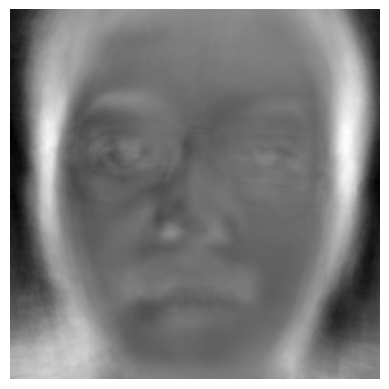

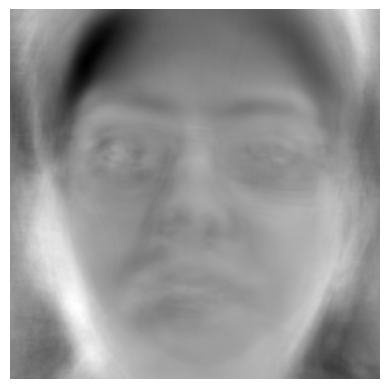

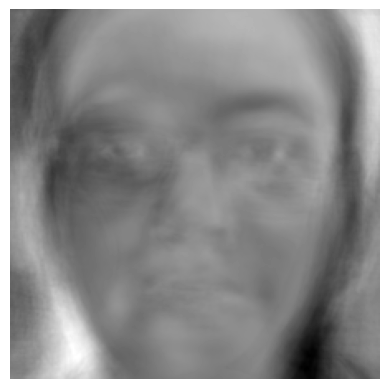

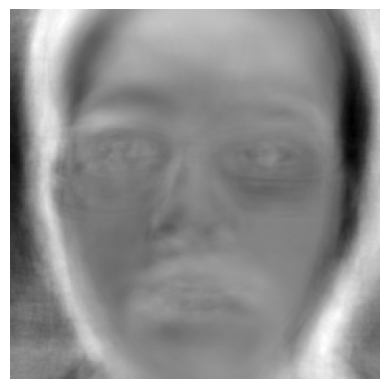

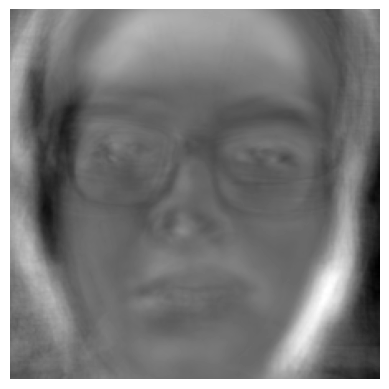

In [23]:
# Reshape the 1D array into a 2D matrix
for i in range(10):
    img = eigen_vector[:,i]
    eigen_image = img.reshape(target_size)
    # Display the grayscale image
    plt.imshow(eigen_image, cmap='gray')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# Normalizing the Eigen Faces

In [24]:
# Calculate the lengths of each eigen vector
vector_lengths = np.linalg.norm(eigen_vector, axis=0)

# Normalize each eigen vector by its own length
normalized_eigen_vectors = eigen_vector / vector_lengths

In [25]:
normalized_eigen_vectors.shape

(50176, 100)

# Projecting the Faces onto the Eigen space

In [26]:
new_images = shifted_images@normalized_eigen_vectors

In [27]:
#weights for train images
new_images.shape

(587, 100)

# Testing Phase

In [28]:
# Extract all 1D NumPy arrays from the test list
test_arrays = [item[0] for item in test_list]

# Shifting the Test Images

In [29]:
shifted_test_images = test_arrays - mean_image

In [30]:
shifted_test_images.shape

(147, 50176)

# Projecting the Test Images onto the Eigen Space

In [31]:
test_weights = shifted_test_images@normalized_eigen_vectors

In [32]:
test_weights.shape

(147, 100)

# Calculating the Threshold

In [33]:
# Calculate the pairwise L2 norm distances between all vectors
pairwise_distances = np.linalg.norm(new_images[:, np.newaxis, :] - new_images[np.newaxis, :, :], axis=-1)

# Set diagonal elements to 0 to avoid calculating distances to itself
np.fill_diagonal(pairwise_distances, 0)

# Find the maximum L2 norm distance
max_distance = np.max(pairwise_distances)

threshold = 0.5*max_distance
print("Threshold:- ",threshold)

Threshold:-  58811.80264167268


# Face verification for test images

In [34]:
def find_index(test_image,threshold):
    # Calculate the L2 norm distances between the test vector and all vectors in the matrix
    distances = np.linalg.norm(new_images - test_image, axis=1)
    
    # Find indices of distances below the threshold
    indices_below_threshold = np.where(distances < threshold)[0]

    # Find the index of the minimum distance among those below the threshold
    index_of_min_distance = indices_below_threshold[np.argmin(distances[indices_below_threshold])]
    
    return index_of_min_distance

In [35]:
predicted = []
actual = []
for i in range(test_weights.shape[0]):
    ind = find_index(test_weights[i],threshold)
    predicted.append(train_list[ind][1])
    actual.append(test_list[i][1])

In [36]:
array1 = np.array(predicted,dtype=object)
array2 = np.array(actual,dtype=object)

# Compare the arrays element-wise and create a new array of 1s and 0s
comparison_result = (array1 == array2).astype(int)

In [37]:
comparison_result

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

# Calculating the Accuracy

In [38]:
cnt = 0
for i in comparison_result:
    if i == 1:
        cnt += 1
print("Accuracy:- ",cnt/len(comparison_result))

Accuracy:-  0.891156462585034
